In [76]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], False)

In [4]:
model_name = 'ViT_model_v1'

In [5]:
home = os.path.expanduser('~')
base = os.path.join('Datasets', 'ImageCLEF', 'Mean_Slice_Masks')

train_dir = os.path.join(home, base, 'train')
test_dir = os.path.join(home, base, 'test')

In [13]:
seed = 42
shuffle = True
inp_shp = (380, 380)
train_batch_size, val_batch_size = 8, 64

train_datagen = keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=inp_shp,
        batch_size=train_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=inp_shp,
        batch_size=val_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

Found 731 images belonging to 5 classes.
Found 184 images belonging to 5 classes.


In [54]:
num_classes = 5
input_shape = (380, 380, 3)

# hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 100
image_size = 380  # We'll resize input images to this size
# Total Patches/image with 19 patch_size = 400
patch_size = 19  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 254
num_heads = 16 #number of heads used for attention
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 24
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [55]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [56]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 380 X 380
Patch size: 19 X 19
Patches per image: 400
Elements per patch: 1083


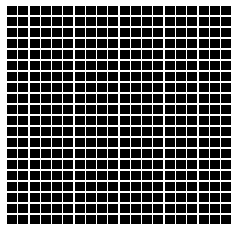

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
batch = next(train_generator)
image = batch[0][:,:,1]
plt.imshow(np.asarray(image))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [58]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [77]:
from tensorflow.python.keras.engine.base_layer import Layer
import collections
import math
import string

import numpy as np

from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers import advanced_activations
from tensorflow.python.keras.layers import core
from tensorflow.python.keras.layers import einsum_dense
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import special_math_ops
from tensorflow.python.util.tf_export import keras_export


_CHR_IDX = string.ascii_lowercase


def _build_attention_equation(rank, attn_axes):
  """Builds einsum equations for the attention computation.
  Query, key, value inputs after projection are expected to have the shape as:
  (bs, <non-attention dims>, <attention dims>, num_heads, channels).
  bs and <non-attention dims> are treated as <batch dims>.
  The attention operations can be generalized:
  (1) Query-key dot product:
  (<batch dims>, <query attention dims>, num_heads, channels), (<batch dims>,
  <key attention dims>, num_heads, channels) -> (<batch dims>,
  num_heads, <query attention dims>, <key attention dims>)
  (2) Combination:
  (<batch dims>, num_heads, <query attention dims>, <key attention dims>),
  (<batch dims>, <value attention dims>, num_heads, channels) -> (<batch dims>,
  <query attention dims>, num_heads, channels)
  Args:
    rank: the rank of query, key, value tensors.
    attn_axes: a list/tuple of axes, [-1, rank), that will do attention.
  Returns:
    Einsum equations.
  """
  target_notation = _CHR_IDX[:rank]
  # `batch_dims` includes the head dim.
  batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
  letter_offset = rank
  source_notation = ""
  for i in range(rank):
    if i in batch_dims or i == rank - 1:
      source_notation += target_notation[i]
    else:
      source_notation += _CHR_IDX[letter_offset]
      letter_offset += 1

  product_notation = "".join([target_notation[i] for i in batch_dims] +
                             [target_notation[i] for i in attn_axes] +
                             [source_notation[i] for i in attn_axes])
  dot_product_equation = "%s,%s->%s" % (source_notation, target_notation,
                                        product_notation)
  attn_scores_rank = len(product_notation)
  combine_equation = "%s,%s->%s" % (product_notation, source_notation,
                                    target_notation)
  return dot_product_equation, combine_equation, attn_scores_rank


def _build_proj_equation(free_dims, bound_dims, output_dims):
  """Builds an einsum equation for projections inside multi-head attention."""
  input_str = ""
  kernel_str = ""
  output_str = ""
  bias_axes = ""
  letter_offset = 0
  for i in range(free_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    output_str += char

  letter_offset += free_dims
  for i in range(bound_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    kernel_str += char

  letter_offset += bound_dims
  for i in range(output_dims):
    char = _CHR_IDX[i + letter_offset]
    kernel_str += char
    output_str += char
    bias_axes += char
  equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

  return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
  return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)


class MultiHeadAttention(Layer):
  """MultiHeadAttention layer.
  This is an implementation of multi-headed attention based on "Attention
  is all you Need". If `query`, `key,` `value` are the same, then
  this is self-attention. Each timestep in `query` attends to the
  corresponding sequence in `key`, and returns a fixed-width vector.
  This layer first projects `query`, `key` and `value`. These are
  (effectively) a list of tensors of length `num_attention_heads`, where the
  corresponding shapes are [batch_size, <query dimensions>, key_dim],
  [batch_size, <key/value dimensions>, key_dim],
  [batch_size, <key/value dimensions>, value_dim].
  Then, the query and key tensors are dot-producted and scaled. These are
  softmaxed to obtain attention probabilities. The value tensors are then
  interpolated by these probabilities, then concatenated back to a single
  tensor.
  Finally, the result tensor with the last dimension as value_dim can take an
  linear projection and return.
  Examples:
  Performs 1D cross-attention over two sequence inputs with an attention mask.
  Returns the additional attention weights over heads.
  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2)
  >>> target = tf.keras.Input(shape=[8, 16])
  >>> source = tf.keras.Input(shape=[4, 16])
  >>> output_tensor, weights = layer(target, source,
  ...                                return_attention_scores=True)
  >>> print(output_tensor.shape)
  (None, 8, 16)
  >>> print(weights.shape)
  (None, 2, 8, 4)
  Performs 2D self-attention over a 5D input tensor on axes 2 and 3.
  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3))
  >>> input_tensor = tf.keras.Input(shape=[5, 3, 4, 16])
  >>> output_tensor = layer(input_tensor, input_tensor)
  >>> print(output_tensor.shape)
  (None, 5, 3, 4, 16)
  Arguments:
    num_heads: Number of attention heads.
    key_dim: Size of each attention head for query and key.
    value_dim:  Size of each attention head for value.
    dropout: Dropout probability.
    use_bias: Boolean, whether the dense layers use bias vectors/matrices.
    output_shape: The expected shape of an output tensor, besides the batch and
      sequence dims. If not specified, projects back to the key feature dim.
    attention_axes: axes over which the attention is applied. `None` means
      attention over all axes, but batch, heads, and features.
    kernel_initializer: Initializer for dense layer kernels.
    bias_initializer: Initializer for dense layer biases.
    kernel_regularizer: Regularizer for dense layer kernels.
    bias_regularizer: Regularizer for dense layer biases.
    activity_regularizer: Regularizer for dense layer activity.
    kernel_constraint: Constraint for dense layer kernels.
    bias_constraint: Constraint for dense layer kernels.
  Call arguments:
    query: Query `Tensor` of shape `[B, T, dim]`.
    value: Value `Tensor` of shape `[B, S, dim]`.
    key: Optional key `Tensor` of shape `[B, S, dim]`. If not given, will use
      `value` for both `key` and `value`, which is the most common case.
    attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
      attention to certain positions.
    return_attention_scores: A boolean to indicate whether the output should
      be attention output if True, or (attention_output, attention_scores) if
      False. Defaults to False.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
      Defaults to either using the training mode of the parent layer/model,
      or False (inference) if there is no parent layer.
  Returns:
    attention_output: The result of the computation, of shape [B, T, E],
      where `T` is for target sequence shapes and `E` is the query input last
      dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
      are project to the shape specified by `output_shape`.
    attention_scores: [Optional] multi-head attention coeffients over
      attention axes.
  """

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False

  def get_config(self):
    config = {
        "num_heads":
            self._num_heads,
        "key_dim":
            self._key_dim,
        "value_dim":
            self._value_dim,
        "dropout":
            self._dropout,
        "use_bias":
            self._use_bias,
        "output_shape":
            self._output_shape,
        "attention_axes":
            self._attention_axes,
        "kernel_initializer":
            initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            constraints.serialize(self._bias_constraint)
    }
    base_config = super(MultiHeadAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def _build_from_signature(self, query, value, key=None):
    """Builds layers and variables.
    Once the method is called, self._built_from_signature will be set to True.
    Args:
      query: query tensor or TensorShape.
      value: value tensor or TensorShape.
      key: key tensor or TensorShape.
    """
    self._built_from_signature = True
    if hasattr(query, "shape"):
      query_shape = tensor_shape.TensorShape(query.shape)
    else:
      query_shape = query
    if hasattr(value, "shape"):
      value_shape = tensor_shape.TensorShape(value.shape)
    else:
      value_shape = value
    if key is None:
      key_shape = value_shape
    elif hasattr(key, "shape"):
      key_shape = tensor_shape.TensorShape(key.shape)
    else:
      key_shape = key

    common_kwargs = dict(
        kernel_initializer=self._kernel_initializer,
        bias_initializer=self._bias_initializer,
        kernel_regularizer=self._kernel_regularizer,
        bias_regularizer=self._bias_regularizer,
        activity_regularizer=self._activity_regularizer,
        kernel_constraint=self._kernel_constraint,
        bias_constraint=self._bias_constraint)
    # Any setup work performed only once should happen in an `init_scope`
    # to avoid creating symbolic Tensors that will later pollute any eager
    # operations.
    with tf_utils.maybe_init_scope(self):
      free_dims = query_shape.rank - 1
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=1, output_dims=2)
      self._query_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="query",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          key_shape.rank - 1, bound_dims=1, output_dims=2)
      self._key_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="key",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          value_shape.rank - 1, bound_dims=1, output_dims=2)
      self._value_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._value_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="value",
          **common_kwargs)

      # Builds the attention computations for multi-head dot product attention.
      # These computations could be wrapped into the keras attention layer once
      # it support mult-head einsum computations.
      self._build_attention(output_rank)
      if self._output_shape:
        if not isinstance(self._output_shape, collections.abc.Sized):
          output_shape = [self._output_shape]
        else:
          output_shape = self._output_shape
      else:
        output_shape = [query_shape[-1]]
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=2, output_dims=len(output_shape))
      self._output_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1, output_shape),
          bias_axes=bias_axes if self._use_bias else None,
          name="attention_output",
          **common_kwargs)

  def _build_attention(self, rank):
    """Builds multi-head dot-product attention computations.
    This function builds attributes necessary for `_compute_attention` to
    costomize attention computation to replace the default dot-product
    attention.
    Args:
      rank: the rank of query, key, value tensors.
    """
    if self._attention_axes is None:
      self._attention_axes = tuple(range(1, rank - 2))
    else:
      self._attention_axes = tuple(self._attention_axes)
    self._dot_product_equation, self._combine_equation, attn_scores_rank = (
        _build_attention_equation(rank, attn_axes=self._attention_axes))
    norm_axes = tuple(
        range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
    self._softmax = advanced_activations.Softmax(axis=norm_axes)
    self._dropout_layer = core.Dropout(rate=self._dropout)

  def _masked_softmax(self, attention_scores, attention_mask=None):
    # Normalize the attention scores to probabilities.
    # `attention_scores` = [B, N, T, S]
    if attention_mask is not None:
      # The expand dim happens starting from the `num_heads` dimension,
      # (<batch_dims>, num_heads, <query_attention_dims, key_attention_dims>)
      mask_expansion_axes = [-len(self._attention_axes) * 2 - 1]
      for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
        attention_mask = array_ops.expand_dims(
            attention_mask, axis=mask_expansion_axes)
    return self._softmax(attention_scores, attention_mask)

  def _compute_attention(self,
                         query,
                         key,
                         value,
                         attention_mask=None,
                         training=None):
    """Applies Dot-product attention with query, key, value tensors.
    This function defines the computation inside `call` with projected
    multi-head Q, K, V inputs. Users can override this function for customized
    attention implementation.
    Args:
      query: Projected query `Tensor` of shape `[B, T, N, key_dim]`.
      key: Projected key `Tensor` of shape `[B, T, N, key_dim]`.
      value: Projected value `Tensor` of shape `[B, T, N, value_dim]`.
      attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
        attention to certain positions.
      training: Python boolean indicating whether the layer should behave in
        training mode (adding dropout) or in inference mode (doing nothing).
    Returns:
      attention_output: Multi-headed outputs of attention computation.
      attention_scores: Multi-headed attention weights.
    """
    # Note: Applying scalar multiply at the smaller end of einsum improves
    # XLA performance, but may introduce slight numeric differences in
    # the Transformer attention head.
    query = math_ops.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

    # Take the dot product between "query" and "key" to get the raw
    # attention scores.
    attention_scores = special_math_ops.einsum(self._dot_product_equation, key,
                                               query)

    attention_scores = self._masked_softmax(attention_scores, attention_mask)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_scores_dropout = self._dropout_layer(
        attention_scores, training=training)

    # `context_layer` = [B, T, N, H]
    attention_output = special_math_ops.einsum(self._combine_equation,
                                               attention_scores_dropout, value)
    return attention_output, attention_scores

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output

ImportError: cannot import name 'einsum_dense' from 'tensorflow.python.keras.layers' (/home/ayushman.singh/anaconda3/envs/tflow/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/__init__.py)

In [71]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
#     augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [72]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.metrics import CohenKappa
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=SigmoidalFocalCrossEntropy(),
        metrics=['acc',CohenKappa(num_classes=5, sparse_labels=True)],
    )

    checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True)

    history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

NameError: name 'initializers' is not defined

In [46]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=64)

history = model.fit(
            train_generator,
            steps_per_epoch=64,
            epochs=256,
            validation_data=val_generator,
            validation_steps=1,
            shuffle=False,
            callbacks=[checkpoint_cb, early_stopping_cb]
)

NameError: name 'model' is not defined

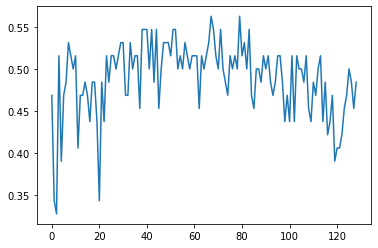

In [20]:
plt.plot(history.history['val_accuracy'])

In [11]:
with open(f'{model_name}_history.pkl', 'wb') as fh:
    pickle.dump(history.history, fh)